In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import pickle as pk
import time
import pandas as pd

import utils as ut
import time
import math
import copy
from sklearn.preprocessing import normalize, MinMaxScaler
from itertools import chain
from GPyOpt.methods import BayesianOptimization
import scipy
from functools import partial

In [2]:
min_max_scaler = MinMaxScaler()

# constants
# rhino uv nurbs +1 (even numbers required?
u = 8 #u = number of points
v = 5 #v = number of platforms
#f_experiment = '200616'
curr_dir_repo = os.getcwd().split('/src/python')[0]
dataset_dir = curr_dir_repo + '/data/' #+ f_experiment
results_dir = curr_dir_repo + '/results/' #+ f_experiment

fn_attr_ranges = 'ranges_attrib.pkl'

###
# THE NOTATION IS
# W for geometries: the points, either on xyz or polar, for each of the platforms
# X for desing attributes: final desired characteristics, like rain occlusion,
# sun occlusion, surface, etc.

flag_polar = True

fname = os.path.join(dataset_dir, 'data_labels_all_200706.pkl')
list_all_dicts = pk.load(open(fname, 'rb'))

# %%

flag_GH_xyz_polar = 0
flag_out_xyz_polar = 0
if flag_polar:
    flag_GH_xyz_polar = 1
    flag_out_xyz_polar = 1

w_train_red, bottom_top_heights = ut.gh_to_script(list_all_dicts, v, u, flag_GH_xyz_polar=flag_GH_xyz_polar,
                                                  flag_out_xyz_polar=flag_out_xyz_polar)

# %%
# Import and preprocess y_train: design attributes


# Attributes to use
list_attrib = ['occlusion_rain', 'occlusion_sun',
               'outline_lengths_0', 'outline_lengths_1', 'outline_lengths_2', 'outline_lengths_3', 'outline_lengths_4',
               'surface_areas_0', 'surface_areas_1', 'surface_areas_2', 'surface_areas_3', 'surface_areas_4']
tot_area_perim_attr = ['surface_area_total','outline_length_total']
x_train = ut.ghlabels_to_script(list_all_dicts, list_attrib, flag_all_df=True)

all_attributes = list(x_train.columns)
print(all_attributes)


num_attr = len(list_attrib) # number of attributes selected for training

#print("Attributes",list_attrib)

total_area_perim  = np.asarray(x_train[tot_area_perim_attr])
total_area_perim = min_max_scaler.fit_transform(total_area_perim)
x_train_red = np.asarray(x_train[list_attrib])

w_nans, ind_not_nanw = ut.check_rows_nan(w_train_red)
x_nans, ind_not_nanx = ut.check_rows_nan(x_train_red)

if len(np.union1d(w_nans, x_nans)):
    ind_not_nan = np.intersect1d(ind_not_nanw, ind_not_nanx)
    print('Reducing samples from {} to {}'.format(len(w_train_red), len(ind_not_nan)))
    w_train_red = w_train_red[ind_not_nan, :]
    x_train_red = x_train_red[ind_not_nan, :]
else:
    print('No nans! ¯\_(ツ)_/¯')


data_dir_loop = '/Users/pouya/vegetale_bayopt'
str_save = 'It1'
flag_save_files = True
max_time = 3600
output_attrib = ['occlusion_rain', 'occlusion_sun']



['cantilever_max', 'occlusion_sun', 'outline_lengths_0', 'outline_lengths_1', 'outline_lengths_2', 'outline_lengths_3', 'outline_lengths_4', 'surface_area_total', 'buildable', 'surface_areas_0', 'surface_areas_1', 'surface_areas_2', 'surface_areas_3', 'surface_areas_4', 'outline_length_total', 'supports_count', 'outlines_bleps', 'occlusion_rain', 'parcel_intersection', 'supports_problems', 'columns_max_length']
No nans! ¯\_(ツ)_/¯


In [3]:
#x_train_red
#w_train_red

# get each platform from the data, 5 per row

w_xyrad = w_train_red[:,:50]
w_heights = w_train_red[:,50:]

w_xyrad = w_xyrad.reshape(w_xyrad.shape[0]*w_xyrad.shape[1],1)
w_heights = w_heights.reshape(w_heights.shape[0]*w_heights.shape[1],1)

In [4]:
w_xyrad = np.reshape(w_xyrad, (-1, 10))


In [6]:
perims = np.asarray(x_train_red[['outline_lengths_0', 'outline_lengths_1', 
                            'outline_lengths_2', 'outline_lengths_3', 'outline_lengths_4']])
areas = np.asarray(x_train_red[['surface_areas_0', 'surface_areas_1', 
                           'surface_areas_2', 'surface_areas_3', 'surface_areas_4']])



IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [6]:
perims_orig = perims
areas_orig = areas

In [7]:
perims = perims.reshape(perims.shape[0]*perims.shape[1],1)
areas = areas.reshape(areas.shape[0]*areas.shape[1],1)

perims = min_max_scaler.fit_transform(perims)
areas = min_max_scaler.fit_transform(areas)


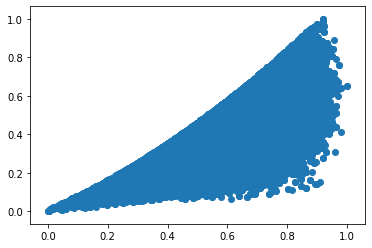

In [8]:
p = np.squeeze(perims)
a = np.squeeze(areas)
plt.scatter(p,a,marker="o")
plt.show()





In [9]:
pa = np.empty((p.shape[0],2))
pa[:,0] = p
pa[:,1] = a

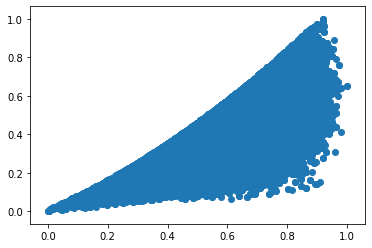

In [10]:
plt.scatter(pa[:,0],pa[:,1],marker="o")
plt.show()



In [11]:
from sklearn.mixture import BayesianGaussianMixture

gmix = BayesianGaussianMixture(weight_concentration_prior_type="dirichlet_distribution",
                               covariance_type="tied",
                               #degrees_of_freedom_prior=1,
                               init_params="random").fit(pa)

In [12]:
import itertools
from scipy import linalg
import matplotlib as mpl

color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold',
                              'darkorange'])

def plot_results(X, Y, means, covariances, index, title):
    splot = plt.subplot(5, 1, 1 + index)
    fig = mpl.pyplot.gcf()
    fig.set_size_inches(18.5, 10.5)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y == i):
            continue
        plt.scatter(X[Y == i, 0], X[Y == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

 
    plt.title(title)
    plt.xticks(())
    plt.yticks(())


def plot_samples(X, Y, n_components, index, title):
    plt.subplot(5, 1, 4 + index)
    for i, color in zip(range(n_components), color_iter):
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y == i):
            continue
        plt.scatter(X[Y == i, 0], X[Y == i, 1], .8, color=color)

    
    plt.title(title)
    plt.xticks(())
    plt.yticks(())


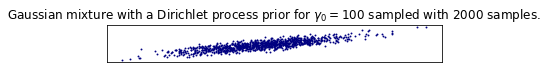

In [13]:
X_s, y_s = gmix.sample(n_samples=1000)
plot_samples(X_s, y_s, gmix.n_components, 1,
             "Gaussian mixture with a Dirichlet process prior "
             r"for $\gamma_0=100$ sampled with $2000$ samples.")
plt.show()

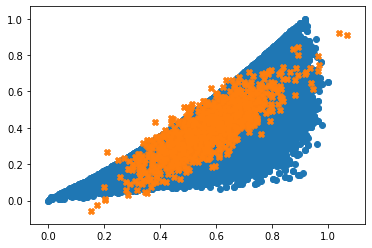

In [14]:
plt.scatter(p,a)
plt.scatter(X_s[:,0],X_s[:,1],marker="X")
plt.show()

In [15]:
params = gmix.get_params()
print(params)

{'covariance_prior': None, 'covariance_type': 'tied', 'degrees_of_freedom_prior': None, 'init_params': 'random', 'max_iter': 100, 'mean_precision_prior': None, 'mean_prior': None, 'n_components': 1, 'n_init': 1, 'random_state': None, 'reg_covar': 1e-06, 'tol': 0.001, 'verbose': 0, 'verbose_interval': 10, 'warm_start': False, 'weight_concentration_prior': None, 'weight_concentration_prior_type': 'dirichlet_distribution'}


In [16]:
dd = gmix.weight_concentration_
print(dd)

[1039361.]


In [17]:
rand_perim = scipy.stats.dirichlet.rvs([10,10,10,10,10], size=100, random_state=1)
rand_area = scipy.stats.dirichlet.rvs([10,10,10,10,10], size=100, random_state=1)




In [18]:

from scipy.stats import norm


# Generate some data for this demonstration.

# Fit a normal distribution to the data:
mu_p, std_p = norm.fit(total_area_perim[:,1])
mean_p = np.mean(perims, axis=0)
cov_p = np.cov(perims, rowvar=0)

mu_a, std_a = norm.fit(total_area_perim[:,0])
mean_a = np.mean(areas, axis=0)
cov_a = np.cov(areas, rowvar=0)
# Plot the histogram.
#plt.hist(x_train_red[:,0], bins=25, density=True, alpha=0.6, color='g')
#plt.hist(x_train_red[:,1], bins=25, density=True, alpha=0.6, color='b')



In [19]:
desired_perims = np.random.normal(loc=mu_p,scale=std_p,size=100)
desired_areas = np.random.normal(loc=mu_a,scale=std_a,size=100)
tot = np.empty((100,2))
tot[:,0] = desired_areas
tot[:,1] = desired_perims

In [20]:
dp = desired_perims[0]
first_four = gmix.sample(n_samples=1)[0][:,1]   
s = 0
count = 0
platforms_perims = np.empty((5))
while s != (dp-0.00001) and count < 5:
    val = gmix.sample(n_samples=1)[0][:,1]  
    if val > 0:
        if s+val < dp:
            s += val
            platforms_perims[count] = val
            count += 1
        
print(platforms_perims)
print(np.sum(platforms_perims))
print(dp)



[0.02973629 0.56330676 0.00745288 0.01668036 0.00109832]
0.6182746114308046
0.6182955584895454


In [ ]:
da = desired_areas[0]
platforms_areas = np.empty((5))
s = 0
count = 0
while s != (da-0.00001) and count < 5:
    val = gmix.sample(n_samples=1)[0][:,0]  
    if val > 0:
        if s+val < da:
            s += val
            platforms_areas[count] = val
            count += 1




print(platforms_areas)
print(np.sum(platforms_areas))
print(da)



In [ ]:
#perim_sam1 = desired_perims[0]
#area_sam1 = desired_areas[0]
areas_res = np.empty((100,5))
perims_res = np.empty((100,5))
for i in range(100):
    areas_res[i,:] = tot[i,0] *rand_area[i,:]
    perims_res[i,:] = tot[i,1] * rand_perim[i,:]


In [ ]:
shit = np.empty((100,5))
shit2 = np.empty((100,5))
for i in range(100):
    
    rand_areas_perims = gmix.sample(n_samples=5)[0]
    shit[i,:] = rand_areas_perims[:,0]#/np.sum(rand_areas_perims[:,0])
    shit2[i,:] = rand_areas_perims[:,1]#/np.sum(rand_areas_perims[:,1])

In [ ]:
p = np.squeeze(perims)
a = np.squeeze(areas)
plt.scatter(p,a,marker="o")
plt.scatter(platforms_perims,platforms_areas,marker="x")
plt.show()




In [30]:
# scale radii
w_ = w_train_red
all_inds = np.arange(0,w_.shape[1])
xy_ind = list(chain.from_iterable((i, i + 1) for i in range(0, 50, 10)))
h_ind = [50, 52, 51]
xyh_inds = xy_ind+h_ind

rad_ind = np.setdiff1d(all_inds,xyh_inds)

scale_values = np.random.uniform(low=0.5,high=2.0,size=(w_.shape[0],rad_ind.size))

w_[:,rad_ind] *= scale_values 

In [33]:
rand_perim = scipy.stats.dirichlet.rvs([12,12,12,12,12], size=1, random_state=1)
rand_area = scipy.stats.dirichlet.rvs([12,12,12,12,12], size=1, random_state=1)




In [34]:
from scipy.stats import norm


# Generate some data for this demonstration.

# Fit a normal distribution to the data:
mu_p, std_p = norm.fit(total_area_perim[:,1])
mean_p = np.mean(perims, axis=0)
cov_p = np.cov(perims, rowvar=0)

mu_a, std_a = norm.fit(total_area_perim[:,0])
mean_a = np.mean(areas, axis=0)
cov_a = np.cov(areas, rowvar=0)
# Plot the histogram.
#plt.hist(x_train_red[:,0], bins=25, density=True, alpha=0.6, color='g')
#plt.hist(x_train_red[:,1], bins=25, density=True, alpha=0.6, color='b')



In [35]:
desired_perims = np.random.normal(loc=mu_p,scale=std_p,size=1)
desired_areas = np.random.normal(loc=mu_a,scale=std_a,size=1)

In [36]:
dir_areas = desired_areas*rand_area
dir_perim = desired_perims*rand_perim

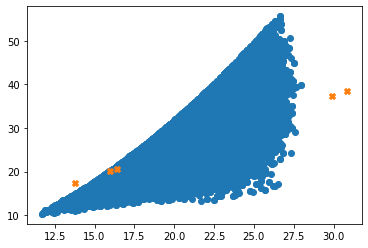

In [37]:
p = np.squeeze(perims)
a = np.squeeze(areas)
plt.scatter(p,a)
plt.scatter(dir_perim,dir_areas,marker="X")
plt.show()

In [10]:
fix_height_inds = list(chain.from_iterable((i+1, i + 2,i+3) for i in range(0, w_xyrad.shape[0], 5)))
lower_height_inds = [i for i in range(0, w_xyrad.shape[0], 5)]
upper_height_inds = [i+4 for i in range(0, w_xyrad.shape[0], 5)]


print(len(fix_height_inds))

623616


In [11]:
platforms = np.empty((w_xyrad.shape[0],11))
platforms[:,:2] = w_xyrad[:,:2]
platforms[:,3:] = w_xyrad[:,2:]
platforms[lower_height_inds,2] = 4.5
platforms[upper_height_inds,2] = 19
platforms[fix_height_inds,2] = np.squeeze(w_heights)

In [12]:
xyz = platforms[:,:3]
mean = np.mean(xyz, axis=0)
cov = np.cov(xyz, rowvar=0)



In [13]:

platforms_perim_area = np.empty((platforms.shape[0],platforms.shape[1]+2-3))
platforms_perim_area[:,:-2] = platforms[:,3:]
platforms_perim_area[:,-2] = np.squeeze(perims)
platforms_perim_area[:,-1] = np.squeeze(areas)

# take a subset to test
small = platforms_perim_area[:1000,:]


In [ ]:
from pomegranate import BayesianNetwork

model = BayesianNetwork.from_samples(small, algorithm='exact')
print(model.structure)

In [ ]:
model.plot()

In [21]:
#needs to be normalized duh
nareas = normalize(areas)
nperims = normalize(perims)
ratio = (areas/perims**2)

In [22]:
rand_perim = scipy.stats.dirichlet.rvs([10,10,10,10,10], size=1, random_state=1)
rand_area = scipy.stats.dirichlet.rvs([10,10,10,10,10], size=1, random_state=1)

print(rand_perim)

[[0.28700923 0.14465838 0.14886033 0.12288716 0.29658489]]


In [23]:
print(ratio)

[[0.07642656]
 [0.06833948]
 [0.06680996]
 ...
 [0.06147886]
 [0.05811824]
 [0.07732989]]


In [24]:
target_rat = np.squeeze(rand_area/rand_perim**2)
idx = np.abs(target_rat-ratio).argmin(axis=0)
val = np.abs(target_rat-ratio).min(axis=0)
print(idx)
print(val)
"""
indices = []
vals = []
for t in target_rat:
    idx = np.abs(t-ratio).argmin()
    val = np.abs(t-ratio).min()
    indices.append(idx)
    vals.append(val)
print(indices)
print(vals)
# pick those platforms 
"""

[3.48420852 6.91283838 6.71770627 8.13754645 3.37171589]
[176900 176900 176900 176900 176900]
[3.40466578 6.83329565 6.63816354 8.05800372 3.29217316]


'\nindices = []\nvals = []\nfor t in target_rat:\n    idx = np.abs(t-ratio).argmin()\n    val = np.abs(t-ratio).min()\n    indices.append(idx)\n    vals.append(val)\nprint(indices)\nprint(vals)\n# pick those platforms \n'

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation as lda

# data generating process: go from ratio to 8 radii
ll = lda(n_components=5)
ll.fit(perims)

In [ ]:
x =ll.transform(rand_perim)
print(x)